## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import netCDF4 as nc
import glob
import datetime
from datetime import timedelta
from collections import defaultdict 
from netCDF4 import Dataset as NetCDFFile 
from datetime import datetime, timedelta
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans, SpectralClustering
from scipy import signal
import xarray as xr
import pylab
import operator
import pickle as pkl
import mpl_toolkits
mpl_toolkits.__path__.append('/home/ninow/packages/basemap-1.1.0/')
from mpl_toolkits.basemap import Basemap

## Define Constants

In [2]:
# paths for data and plots
baseline_experiment_path ='/mnt/ds3lab-scratch/ninow/final_results/baseline/bias_corrected_baseline/'
observations_path = '/mnt/ds3lab-scratch/ninow/observations/meteoswiss_t2m_20151001-20180331.nc'
time_invariant_grid_data_path = '/mnt/ds3lab-scratch/ninow/topo/topodata.nc'
destination = '/mnt/ds3lab-scratch/ninow/final_results/baseline/final_plots'

## Load Data

In [9]:
# load 3d distance baseline results
lead_time_baseline_error = None
for path in glob.glob(baseline_experiment_path + '/3d_distance/**/experiment_statistic.pkl', recursive=True):
    run = path[-30:-25]
    with open(path, 'rb') as file:
        ds = pkl.load(file)
    
    try:
        lead_time_baseline_error = xr.concat((lead_time_baseline_error, ds.error_statistic), 'run')
    except:
        print('First')
        lead_time_baseline_error = ds.error_statistic
mean_rmse_per_lead_time_baseline = np.mean(np.sqrt(np.nanmean(np.square(lead_time_baseline_error), axis=(2,3,4,6))), axis=0)

First


### Model test error

In [4]:
lead_time_model_error = None
for lead_time in np.arange(1,32,5):
    ds = pkl.load(open('/mnt/ds3lab-scratch/ninow/final_results/network/lead_time_prediction/experiment/lead_time_%s/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/experiment_statistic.pkl' % lead_time,'rb'))
    
    error_test_error = ds.error_statistic.sel(error = 'test')
    best_epoch = np.argmin(np.nanmean(error_test_error, axis=0),axis=0).item()
    error_test_error = error_test_error.sel(epoch = best_epoch)
    try:
        lead_time_model_error = xr.concat((lead_time_model_error, error_test_error), 'prediction_times')
    except:
        print('First')
        lead_time_model_error = error_test_error
min_mean_rmse_per_lead_time = np.nanmean(lead_time_model_error, axis=0)

Error


### Model training error

In [7]:
lead_time_model_error_training = None
for lead_time in np.arange(1,32,5):
    ds = pkl.load(open('/mnt/ds3lab-scratch/ninow/final_results/network/lead_time_prediction/experiment/lead_time_%s/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/experiment_statistic.pkl' % lead_time,'rb'))
    
    error_test_error = ds.error_statistic.sel(error = 'train')
    best_epoch = np.argmin(np.nanmean(error_test_error, axis=0),axis=0).item()
    error_test_error = error_test_error.sel(epoch = best_epoch)
    try:
        lead_time_model_error_training = xr.concat((lead_time_model_error_training, error_test_error), 'prediction_times')
    except:
        print('First')
        lead_time_model_error_training = error_test_error
min_mean_rmse_per_lead_time_training = np.nanmean(lead_time_model_error_training, axis=0)

First


## Plot lead time prediction results test

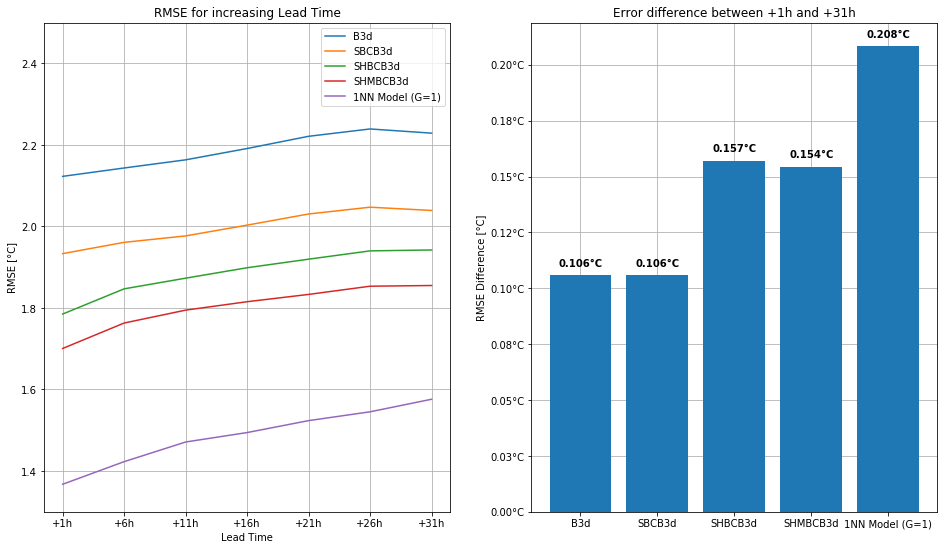

In [6]:
baseline_names = ['B3d', 'SBCB3d', 'SHBCB3d', 'SHMBCB3d']

fix, ax = plt.subplots(1,2, figsize=(16,9))

#plot rmse per lead time
for idx, rmse in enumerate(mean_rmse_per_lead_time_baseline.T):
    ax[0].plot(np.arange(1,32,5), rmse[list(np.arange(1,32,5))], label=baseline_names[idx])
ax[0].plot(np.arange(1,32,5), min_mean_rmse_per_lead_time, label='1NN Model (G=1)')
ax[0].set_xlabel('Lead Time')
ax[0].set_xticks(np.arange(1,32,5))
ax[0].set_xticklabels(['+%sh' % h for h in np.arange(1,32,5)])
ax[0].set_ylabel('RMSE [°C]')
ax[0].set_ylim(1.3,2.5)
ax[0].legend(loc='upper right')
ax[0].grid(True)
ax[0].set_title('RMSE for increasing Lead Time')

# plot forecast skill of +31h vs. +1h
diff_baselines = mean_rmse_per_lead_time_baseline[31] - mean_rmse_per_lead_time_baseline[1]
diff_model = min_mean_rmse_per_lead_time[-1] - min_mean_rmse_per_lead_time[0]
diff_results = list(diff_baselines) + [diff_model]

ax[1].bar(np.arange(0,5), diff_results, zorder=3)

for i, v in enumerate(diff_results):
    ax[1].text(i-0.28, v+4e-3, "%.3f°C" % (v), color='black', fontweight='bold')

ax[1].set_xticks(np.arange(0,5))
ax[1].set_xticklabels(baseline_names + ['1NN Model (G=1)'])
ax[1].set_ylabel('RMSE Difference [°C]')
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: "%.2f°C" % (x)))
ax[1].set_title('Error difference between +1h and +31h')
ax[1].grid(zorder=0)

plt.show()

### Calculate the difference of model RMSE between +1h and +31h to show, that the increase is much smaller than for the test set

In [13]:
# Difference of model RMSE between +1h and +31h on training set
diff_model = min_mean_rmse_per_lead_time_training[-1] - min_mean_rmse_per_lead_time_training[0]
diff_model

0.1388140468203396